# **Predicting Kilocalories Based on Nutritional Information**
*Exploratory Data Analysis* | *Feature Selection* | *Model Building* | *Model Evaluation* | *Regression* | *AutoML* | *SHAP Values*

* Author: Vishnu Rao-Sharma
* Published: Fall 2023

## Abstract
With this dataset, I intend to find the relationship between macro/micro nutrients and Kilocalories in food. I will use SHRUTI SAXENA's [Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv) which is based on the USDA's [FoodData Central database](https://fdc.nal.usda.gov/fdc-app.html#/) to build a models that can predict the calories in a food based on key nutritional information. 

To begin, I preprocess the raw dataset and analyze the incoming dataset. This analysis helped determine the most important for predicting calories:
* 

Using these selected features, I build a few models with the selected features using the following regression techniques:
* OLS Linear Regression
* AutoML's Best (Non-Stacked) Model
* Gradient Boosting Machine (GBM)

Before evaluating the models, I perform a grid search with k=5 cross-validation to find solid hyperparameters for the non-linear regression models. 

Finally, I compare model accuracy on the test set based on RMSE, and compare interpretability with feature SHAP values. This evaluation finds that the model built using UPDATE had the lowest RMSE. 

## Preparing Libraries and Setting-up AutoML
Before we get into the dataset, let's start by getting our packages, libraries, and Auto-ML config in order

In [2]:
# Installing necessary pkgs
!pip install --upgrade pip
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install shap
!pip install xgboost
!pip install gbm
!pip3 install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [3]:
# Importing libs
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
import psutil
import random
import logging
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from statistics import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import VarianceThreshold
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import bias_variance_decomp

In [4]:
# Setting up H2O VM
min_mem_size=6 
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

port_no=random.randint(5555,55555)
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)    
  h2o.cluster().shutdown()
  sys.exit(2)

1
Checking whether there is an H2O instance running at http://localhost:52127..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4" 2022-07-19; OpenJDK Runtime Environment Temurin-17.0.4+8 (build 17.0.4+8); OpenJDK 64-Bit Server VM Temurin-17.0.4+8 (build 17.0.4+8, mixed mode)
  Starting server from /Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmp1xc9_rzq
  JVM stdout: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmp1xc9_rzq/h2o_vraosharma_started_from_python.out
  JVM stderr: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmp1xc9_rzq/h2o_vraosharma_started_from_python.err
  Server is running at http://127.0.0.1:52127
Connecting to H2O server at http://127.0.0.1:52127 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_vraosharma_vbo69t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Importing and Pre-processing the Dataset
In this section we will evaluate the hygiene of the dataset and clean it up as necessary.

In [5]:
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vishnuraosharma/exploratory-data-analysis/main/Kcal%20Predictions/food.csv

zsh:1: command not found: wget


In [6]:
#Reading the file into a dataframe and viewing the first few rows
df = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in df.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    df.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
df.head()

,Category,Description,Nutrient Data Bank Number,Alpha Carotene,Ash,Beta Carotene,Beta Cryptoxanthin,Carbohydrate,Cholesterol,Choline,...,Major Minerals.Potassium,Major Minerals.Sodium,Major Minerals.Zinc,Vitamins.Vitamin A - IU,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


As we can see above, each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. Some foods have multiple entries in the dataset because they were prepared in different ways, e.g. raw, cooked, fried, etc. Additionally, some foods have multiple entries because they were prepared with different ingredients, e.g. with or without salt, with or without sugar, etc.

The consistency of the data also presents a challenge. For example, the *Category* column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I am not sure if this is intentional or not, but I will leave this data as is for now. To clean this up, I could use GPT to classify the foods into categories, but that is outside the scope of this project.

In [7]:
# Show a description of each col
df.describe()

,Nutrient Data Bank Number,Alpha Carotene,Ash,Beta Carotene,Beta Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Fiber,Kilocalories,...,Major Minerals.Potassium,Major Minerals.Sodium,Major Minerals.Zinc,Vitamins.Vitamin A - IU,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,...,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000
mean,14116.443680,21.210711,1.852459,159.043437,8.776744,21.785381,37.162822,20.673546,1.993147,219.655875,...,268.348172,331.590719,1.875125,767.568191,99.437070,1.172903,0.269547,9.075651,0.842837,9.448604
std,8767.416214,269.714183,2.993228,1126.285026,154.184860,27.123491,119.738438,45.481990,4.292873,171.668713,...,404.916220,977.046544,4.193682,3871.307652,761.653061,4.512816,0.565116,63.443284,4.169756,66.067619
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8121.000000,0.000000,0.830000,0.000000,0.000000,0.490000,0.000000,0.000000,0.000000,82.000000,...,103.000000,31.000000,0.190000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000
50%,12539.000000,0.000000,1.240000,0.000000,0.000000,9.290000,2.000000,0.000000,0.300000,181.000000,...,210.000000,86.000000,0.770000,33.000000,0.000000,0.010000,0.110000,0.000000,0.050000,0.000000
75%,18424.000000,0.000000,2.200000,1.000000,0.000000,30.590000,60.000000,20.000000,2.300000,331.000000,...,328.000000,428.000000,2.460000,280.000000,24.000000,0.830000,0.330000,3.500000,0.390000,1.700000
max,93600.000000,14251.000000,99.800000,42891.000000,7923.000000,100.000000,3100.000000,1388.000000,79.000000,902.000000,...,16500.000000,38758.000000,181.610000,100000.000000,30000.000000,98.890000,12.000000,2400.000000,149.400000,1714.500000


Looking at the means, std. deviations, mins, and maxes, of each of our fields we can see that our data needs to be evaluated column by column to determine if each field makes sense. At face value, a mean of 21.8 for Carbohydrates and 37.2 for Cholesterol seems off, but we need to consider the units of each column. 

Of course, we will treat the Data Bank Number as a surrogate key and disregard its distribution. Similarly, Category and Description are categorical variables and we will them in our unit analysis.

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
1. Ash: g
2. Alpha Carotene: µg
3. Beta Carotene: µg
4. Beta Cryptoxanthin: µg
5. Carbohydrate: g
6. Cholesterol: mg
7. Choline: mg
8. Fat.Monosaturated Fat: g
9. Fat.Polysaturated Fat: g
10. Fat.Saturated Fat: g
11. Fat.Total Lipid: g
12. Fiber: g
13. Household Weights.1st Household Weight: g
14. Kilocalories: kcal
15. Lutein and Zeaxanthin: µg
16. Lycopene: µg
17. Major Minerals.Calcium: mg
18. Major Minerals.Copper: mg
19. Major Minerals.Iron: mg
20. Major Minerals.Magnesium: mg
21. Major Minerals.Phosphorus: mg
22. Major Minerals.Potassium: mg
23. Major Minerals.Sodium: mg
24. Major Minerals.Zinc: mg
25. Manganese: mg
26. Niacin: mg
27. Pantothenic Acid: mg
28. Protein: g
29. Refuse Percentage: % by volume
30. Retinol: µg
31. Riboflavin: mg
32. Selenium: µg
33. Sugar Total: g
34. Thiamin: mg
35. Vitamins.Vitamin A - RAE: µg
36. Vitamins.Vitamin B12: µg
37. Vitamins.Vitamin B6: µg
38. Vitamins.Vitamin C: µg
39. Vitamins.Vitamin E: mg
40. Vitamins.Vitamin K: µg
41. Water: g

Below, we can see the data types in this dataset are object (string), float64, and int64.

In [8]:
# Show data types and count of attributes per that type
df.dtypes.value_counts()

float64    25
int64      19
object      4
Name: count, dtype: int64

As we can see below, there are only null values in the two 'Household Weight Description' columns.

In [9]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Household Weights.2nd Household Weight Description    41.818427
Household Weights.1st Household Weight Description     6.340213
Category                                               0.000000
Description                                            0.000000
Fat.Polysaturated Fat                                  0.000000
Fat.Saturated Fat                                      0.000000
Fat.Total Lipid                                        0.000000
Household Weights.1st Household Weight                 0.000000
Household Weights.2nd Household Weight                 0.000000
Major Minerals.Calcium                                 0.000000
Major Minerals.Copper                                  0.000000
Major Minerals.Iron                                    0.000000
Major Minerals.Magnesium                               0.000000
Major Minerals.Phosphorus                              0.000000
Major Minerals.Potassium                               0.000000
Major Minerals.Sodium                   

Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

Also, because Household Weight Description doesn't really tell us anything that the *Household Weights.1st Household Weight* already containes, we will drop *Household Weights.1st Household Weight Description* as well.

In [10]:
# Drop 'Household Weight Description' columns
df.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight','Household Weights.1st Household Weight Description'], axis=1, inplace=True)

Despite having only non-null values, both categorical and numeric attributes of this dataset have a few "placeholder" values. Let's quantify these.

In [11]:
# Find the number of values in the 'Category' column that ci match '%no category%'
df[df['Category'].str.contains('no category', case=False)]['Category'].count()/ len(df)

0.026709834075273168

We can see that the *Category* column has less than 3% of its values labeled 'no category'. This is not a significant amount of data. Because we're trying to predict Kilocalories, and we don't care too much about the taxonomy of food types, we will keep these records.

Let's now target the numeric columns. We will look for values that are 0, which are likely placeholders for missing data.

In [12]:
# Show the percentage of 0s in each numeric column of the dataset. In another table, show the percentage of 1s in each numeric column of the dataset.
df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x[x == 0].count() / len(df)).sort_values(ascending=False)

Lycopene                                  0.966275
Beta Cryptoxanthin                        0.920005
Alpha Carotene                            0.918117
Refuse Percentage                         0.804667
Lutein and Zeaxanthin                     0.788075
Beta Carotene                             0.739512
Retinol                                   0.716444
Vitamins.Vitamin K                        0.571024
Choline                                   0.547552
Vitamins.Vitamin A - RAE                  0.508701
Vitamins.Vitamin C                        0.505733
Vitamins.Vitamin B12                      0.499933
Sugar Total                               0.482800
Cholesterol                               0.476190
Fiber                                     0.461082
Vitamins.Vitamin E                        0.458249
Vitamins.Vitamin A - IU                   0.362067
Manganese                                 0.244975
Selenium                                  0.242277
Pantothenic Acid               

Because we're dealing with a variety of foods, it makes sense that certain nutrients would be absent, so we will not impute any of these values. However, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0.

In [13]:
# Drop rows where Household Weights.1st Household Weight is 0
df = df[df['Household Weights.1st Household Weight'] != 0]

Next, let's limit the scope of our dataset to exclude information that gives is found in small quantities in food. We will remove the following columns to simplify our analysis because we don't care about their correlation to KCAL:
1. **Alpha Carotene**
2. **Beta Carotene**
3. **Beta Cryptoxanthin**
4. **Lycopene**
5. **Lutein and Zeaxanthin**
6. **Retinol**
7. **Riboflavin**
8. **Selinium**
9. **Thiamin**
10. **Choline**
11. **Manganese**
12. **Niacin**
13. **Pantothenic Acid**
14. **Refuse Percentage**

In [14]:
# Drop columns that are not relevant to our analysis
df.drop(['Alpha Carotene', 'Beta Carotene', 'Beta Cryptoxanthin', 'Lycopene', 'Lutein and Zeaxanthin', 'Retinol', 'Riboflavin', 'Selenium', 'Thiamin', 'Choline', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Refuse Percentage'], axis=1, inplace=True)

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [15]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
df.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

## Data Profiling
Now that we’ve cleaned up the dataset, let’s see the distributions of the numeric variables. We will use a histogram to visualize the distributions of the numeric variables.

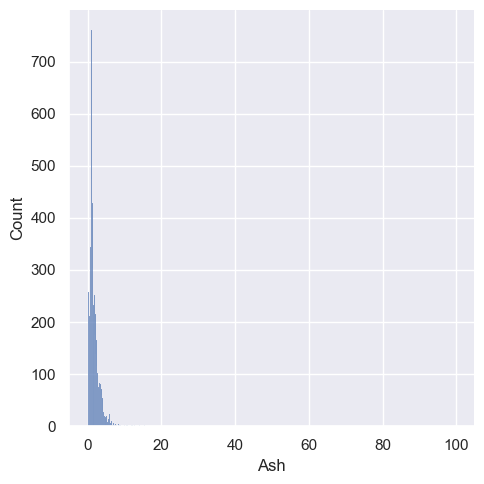

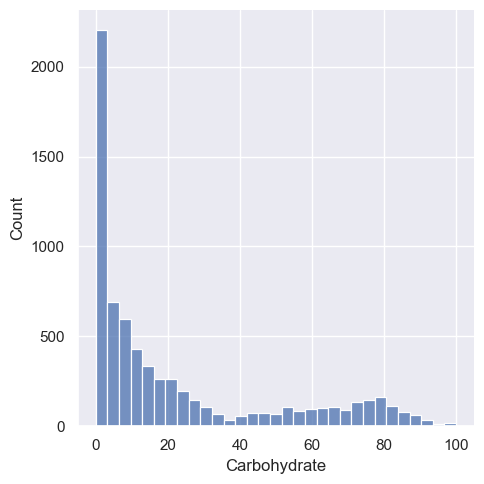

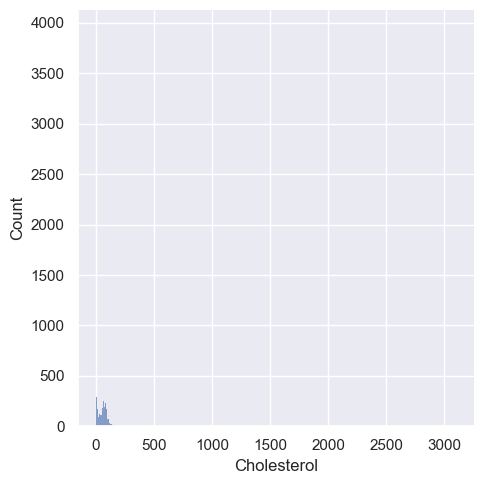

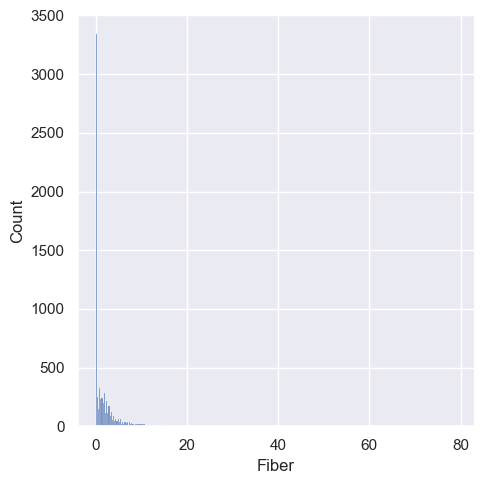

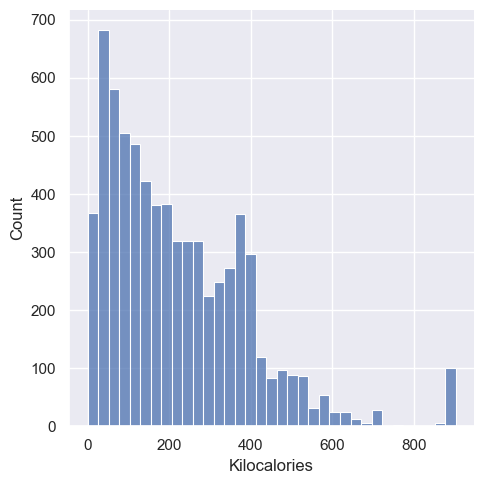

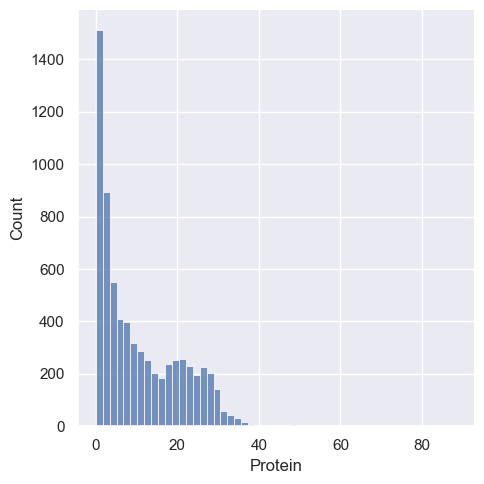

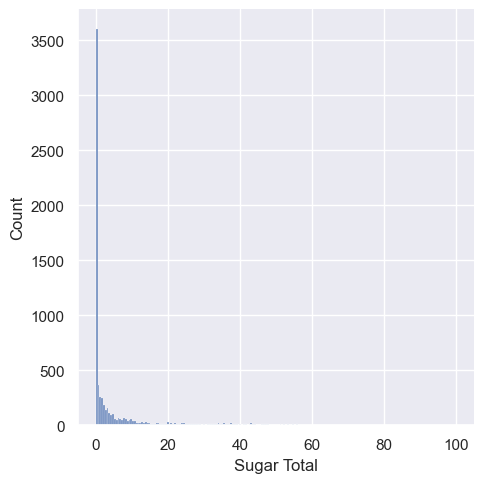

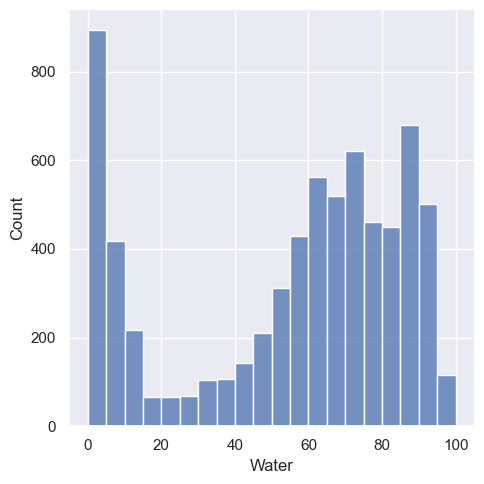

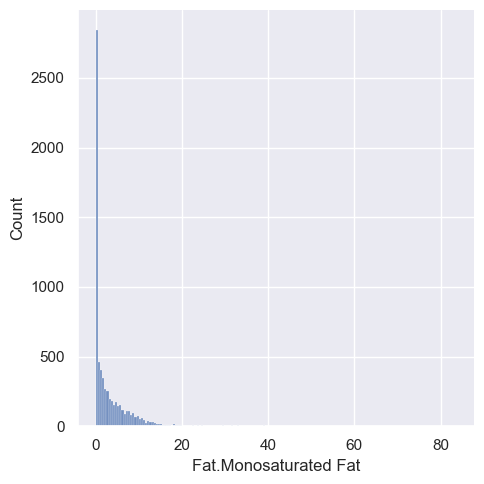

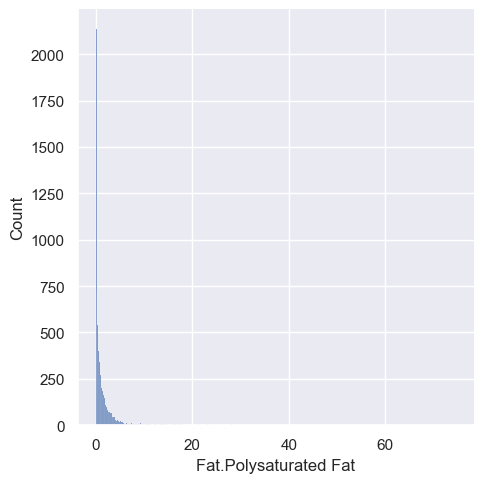

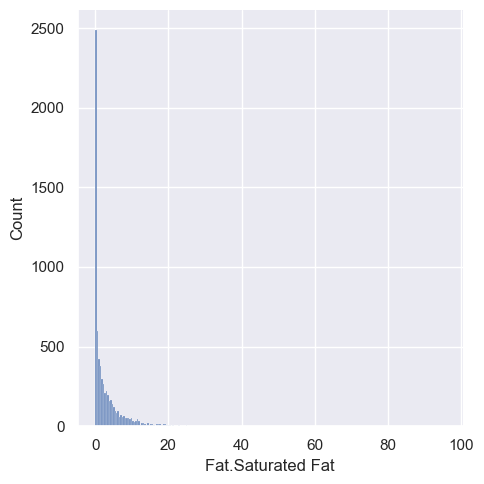

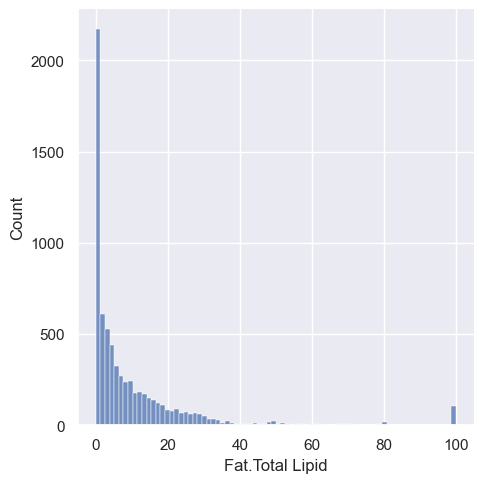

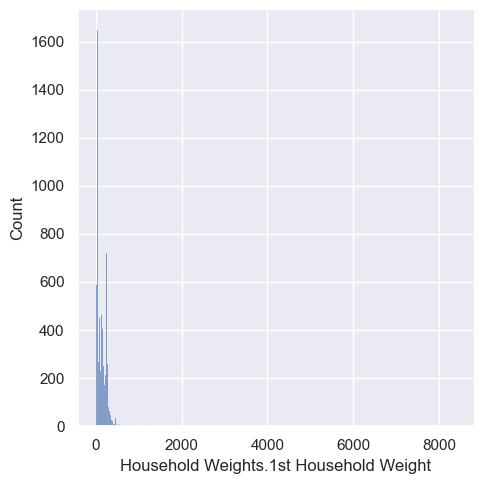

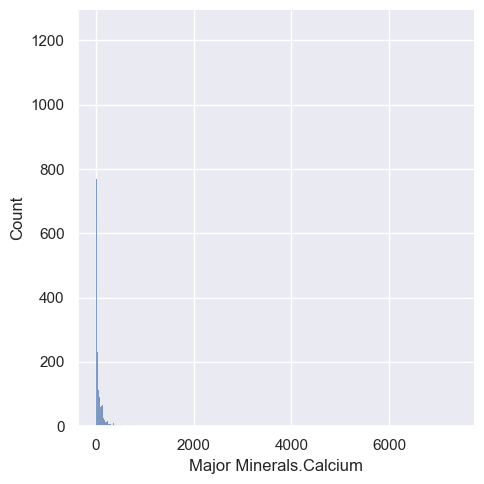

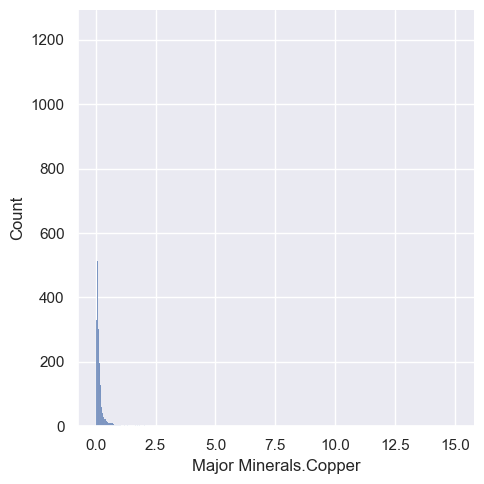

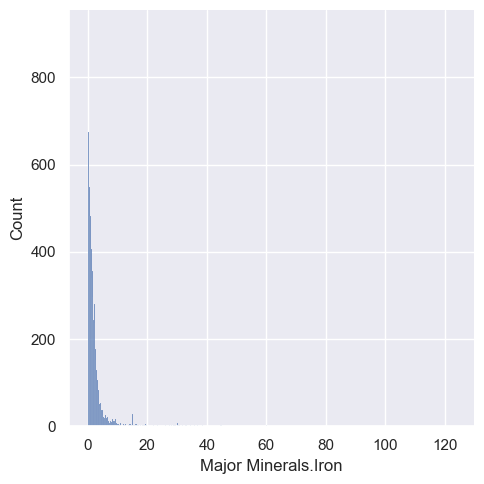

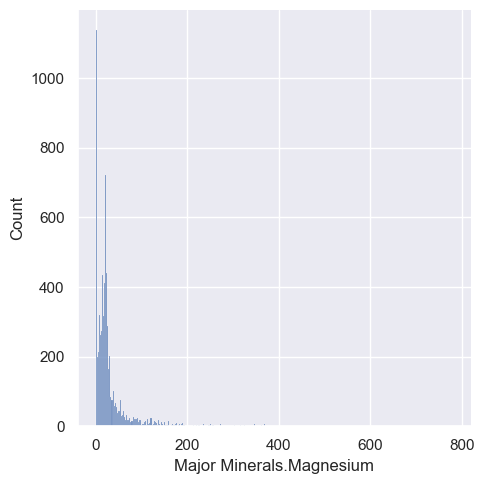

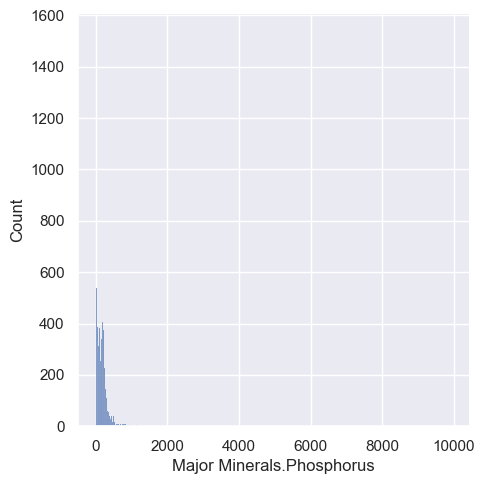

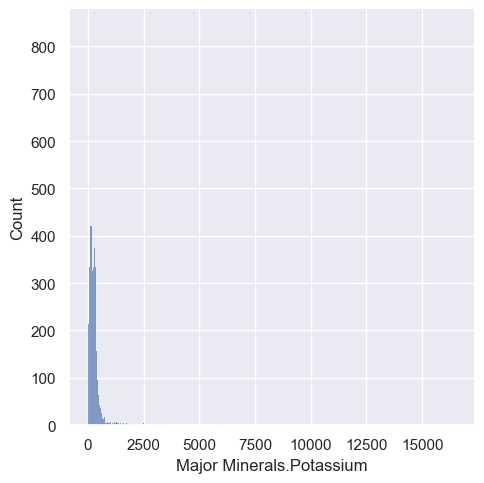

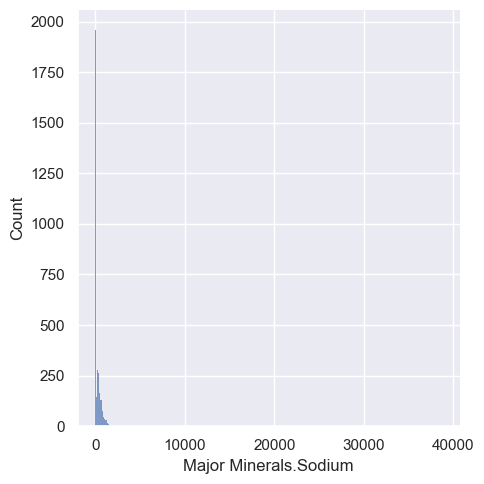

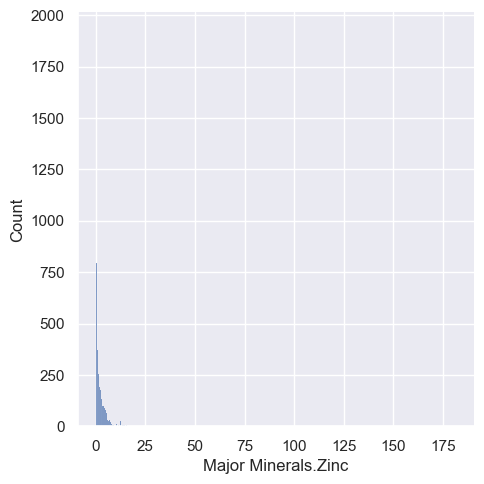

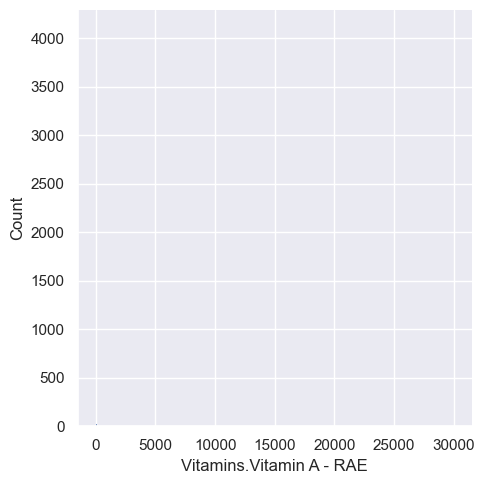

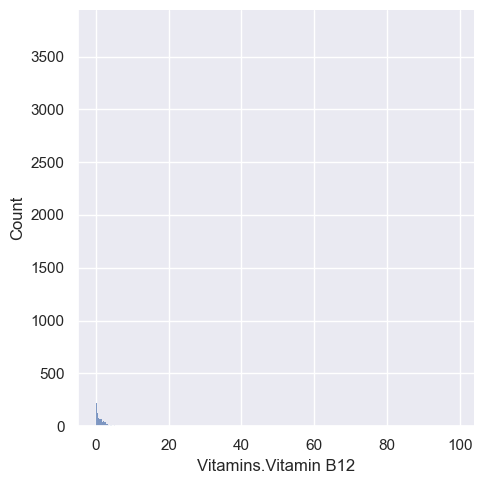

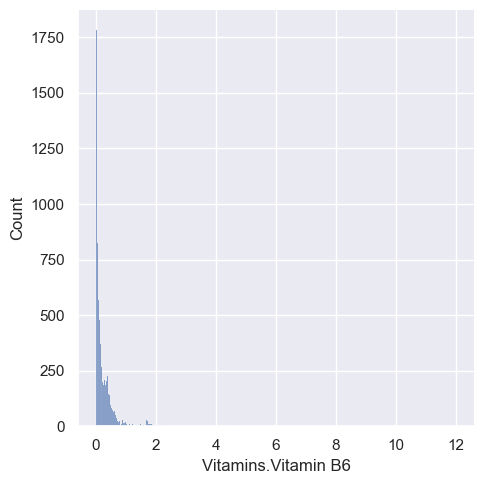

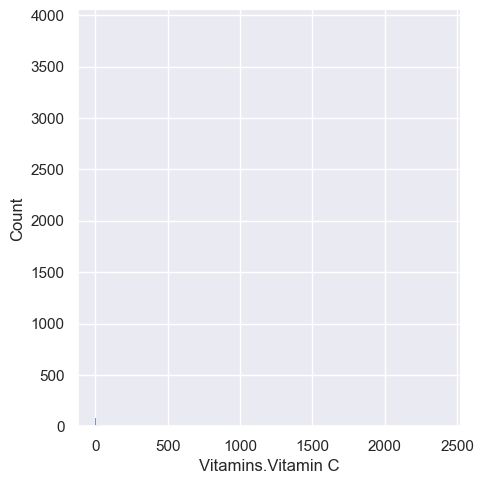

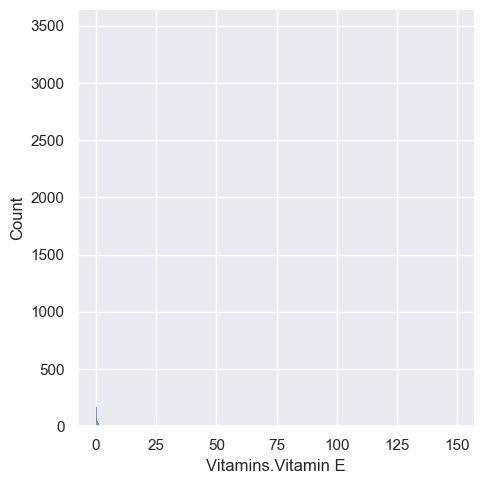

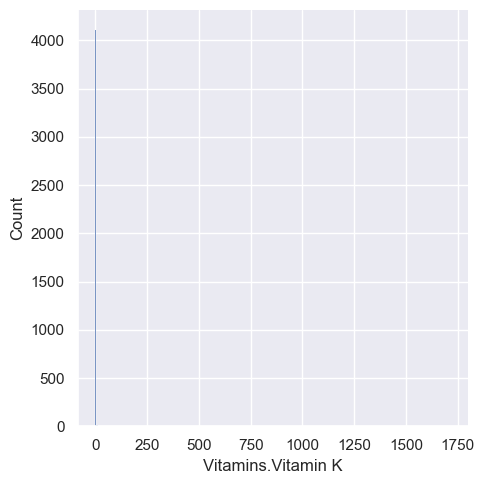

In [16]:
# Add the numeric columns excluding Nutrient Data Bank Number to a list
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

#create a histogram for each numeric column
for column in numeric_cols.columns:
    sns.set(rc={"figure.figsize": (8, 4)})
    sns.displot(df[column])
    plt.show()

We can see that the distributions of the numeric variables are very right-tailed. This is expected - for example, some foods are very rich in Vitamin A like Cod Liver, while others have none.

The only variable that looks roughly normal is *Water*. Let's perform the Shapiro-Wilk test to verify if Water's or any other of the distributions are normal.

In [17]:
# Perform the Shapiro-Wilk test on each numeric column excluding Nutrient Data Bank Number
for column in numeric_cols.columns:
    stat, p = shapiro(df[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('{} looks Normal (fail to reject H0)'.format(column))
    else:
        print('{} does not look Normal (reject H0)'.format(column))

Statistics=0.338, p=0.000
Ash does not look Normal (reject H0)
Statistics=0.779, p=0.000
Carbohydrate does not look Normal (reject H0)
Statistics=0.234, p=0.000
Cholesterol does not look Normal (reject H0)
Statistics=0.487, p=0.000
Fiber does not look Normal (reject H0)
Statistics=0.899, p=0.000
Kilocalories does not look Normal (reject H0)
Statistics=0.867, p=0.000
Protein does not look Normal (reject H0)
Statistics=0.533, p=0.000
Sugar Total does not look Normal (reject H0)
Statistics=0.881, p=0.000
Water does not look Normal (reject H0)
Statistics=0.530, p=0.000
Fat.Monosaturated Fat does not look Normal (reject H0)
Statistics=0.367, p=0.000
Fat.Polysaturated Fat does not look Normal (reject H0)
Statistics=0.472, p=0.000
Fat.Saturated Fat does not look Normal (reject H0)
Statistics=0.609, p=0.000
Fat.Total Lipid does not look Normal (reject H0)
Statistics=0.359, p=0.000
Household Weights.1st Household Weight does not look Normal (reject H0)
Statistics=0.281, p=0.000
Major Minerals.C

/Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As we can see above, none of the distributions are normal. This is expected because the distributions are right-tailed.

## Feature Selection
Now that we have an idea of what we're working with, let's see which columns are the most useful for predicting Kilocalories. We will use three methods to determine which features are the most useful:
1. **Pearson's Correlation**: We will use Pearson's Correlation to determine which features are the most correlated to Kilocalories. We will use a threshold of 0.5.
2. **Sequential Feature Selection**: We will use Sequential Feature Selection to determine which features are the most useful. We will use a linear regression model to determine the best features. We will use a step size of 1 and a cross-validation of 5.
3. **Variance Thresholding**: We will use Variance Thresholding to determine which features are the most useful. We will use a threshold of 0.2.

First up, let's use ***Pearson's Correlation*** look at the relationships between *Kilocalories* and the other numeric variables.

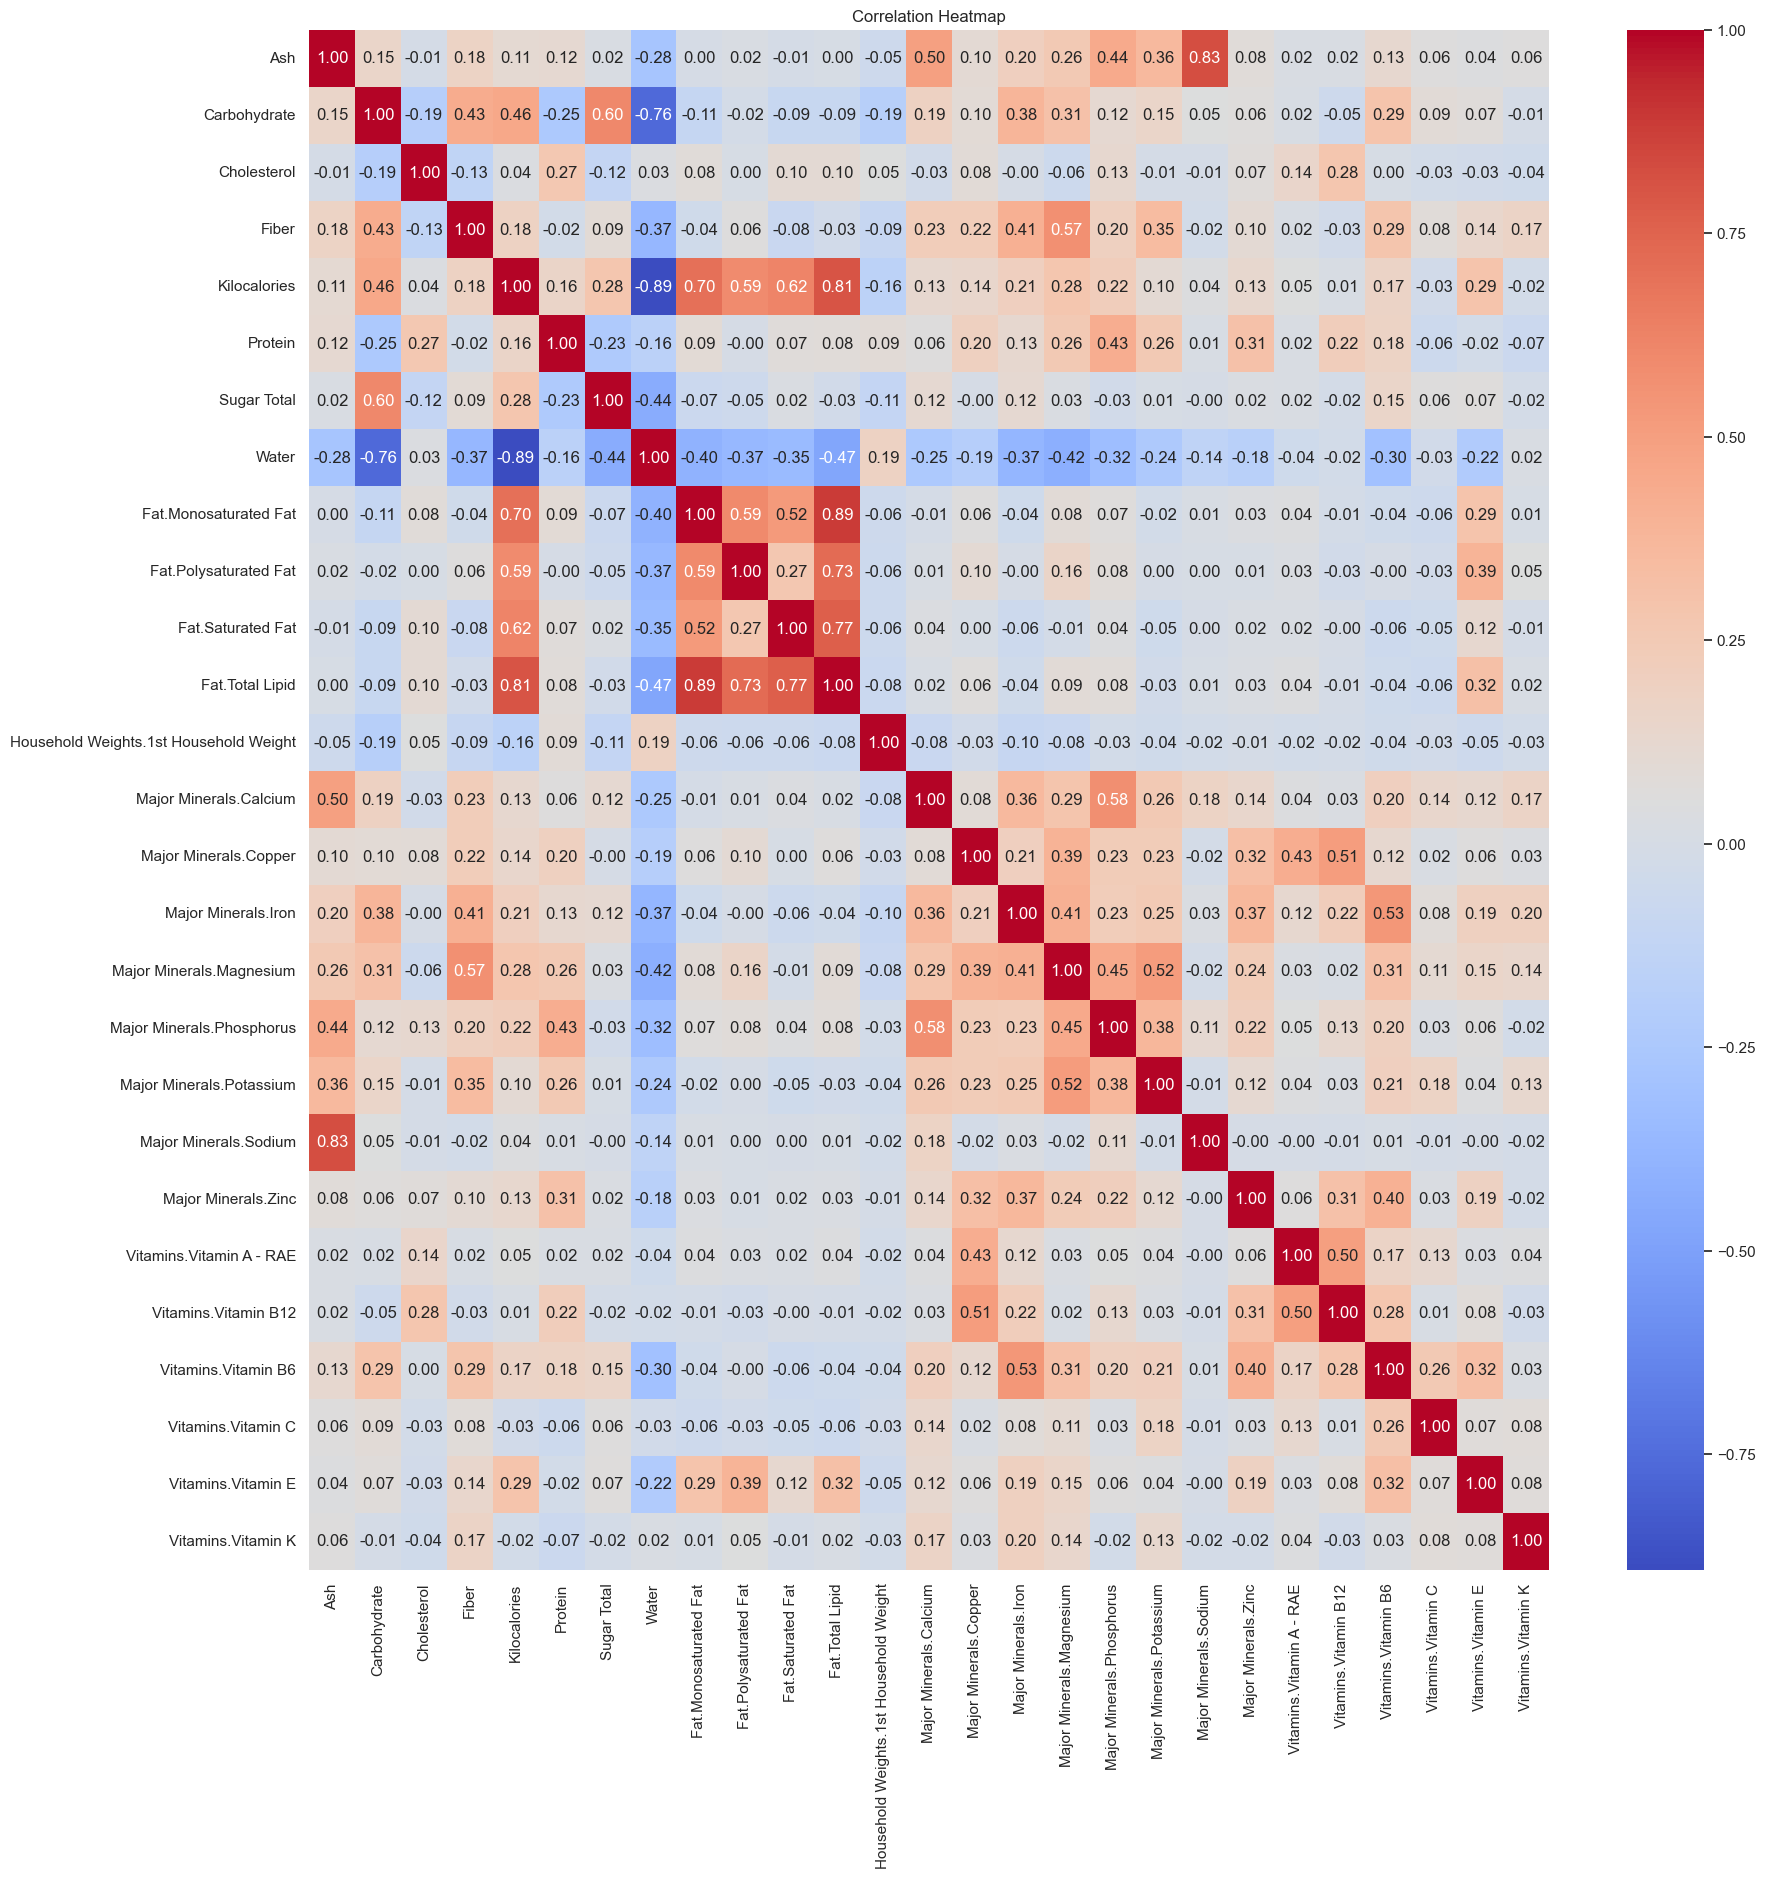

In [18]:
# Create a copy of the dataset
df_fs_correlation = df.copy()

# Only keep feature candidates
df_fs_correlation = df_fs_correlation.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

# Create a correlation matrix of all independent variables
corr_matrix = df_fs_correlation.corr()

# Create a heatmap of all independent variables
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

A few things jump out at us from the heatmap that will help us narrow down our features:
1.  *Fat.Total Lipid* and the other sub-types of fat (e.g. *Monounsaturated*, *Saturated*) are highly correlated to each other. This makes sense because Total Lipid is the sum of the other sub-types of fat. Because we are trying to predict *Kilocalories*, we will keep *Fat.Total Lipid* and drop the other sub-types of fat. The high correlation shows us that Total Fat will likely be our best predictor of Calories and this will help mitigate the multi-collinearity between the sub-types of fat.
2. Water's negative correlation to *Kilocalories* will likely make it a great feature to keep. Because foods like vegetables are mostly water and have few calories this makes sense.
3. Major Minerals seem to be clustered together as well, for example *Calcium* and *Phosphorus* are highly correlated. None of these minerals are highly correlated to *Kilocalories*, so we will drop them.
4. Interestingly *Sodium* and *Ash* are highly correlated. The relationship between these two is not clear. Because we dropped Sodium in the previous step, we will keep Ash.
5. Vitamins in this dataset appear to be clustered together as well. None of these vitamins are highly correlated to *Kilocalories*, with an exception of *Vitamin E*. In order to satisfy the requirements of the assignment to use a categorical variable, we will introduce a new feature called *Vitamin E Present* that will be a binary variable indicating whether or not a food contains Vitamin E.

In [19]:
# Create a dummy column called 'Vitamin E Present' that is 1 if Vitamin E is present and 0 if it is not
df['Vitamin E Present'] = np.where(df['Vitamins.Vitamin E'] > 0, 1, 0)

# Create a dummy column called 'Vitamin E Present' that is 1 if Vitamin E is present and 0 if it is not
df_fs_correlation['Vitamin E Present'] = np.where(df_fs_correlation['Vitamins.Vitamin E'] > 0, 1, 0)

In [20]:
# Drop columns that Pearson's test highlighted as not useful above
df_fs_correlation.drop(['Fat.Monosaturated Fat', 'Fat.Polysaturated Fat', 'Fat.Saturated Fat', 'Major Minerals.Calcium', 'Major Minerals.Copper', 'Major Minerals.Iron', 'Major Minerals.Magnesium', 'Major Minerals.Phosphorus', 'Major Minerals.Potassium', 'Major Minerals.Sodium', 'Major Minerals.Zinc', 'Vitamins.Vitamin A - RAE', 'Vitamins.Vitamin B12', 'Vitamins.Vitamin B6', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E', 'Vitamins.Vitamin K'], axis=1, inplace=True)

# Show our current Feature Set after analysis of Pearson's Correlation
df_fs_correlation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6943 entries, 0 to 7409
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Ash                                     6943 non-null   float64
 1   Carbohydrate                            6943 non-null   float64
 2   Cholesterol                             6943 non-null   int64  
 3   Fiber                                   6943 non-null   float64
 4   Kilocalories                            6943 non-null   int64  
 5   Protein                                 6943 non-null   float64
 6   Sugar Total                             6943 non-null   float64
 7   Water                                   6943 non-null   float64
 8   Fat.Total Lipid                         6943 non-null   float64
 9   Household Weights.1st Household Weight  6943 non-null   float64
 10  Vitamin E Present                       6943 non-null   int64  
d

Next, let's use ***Sequential Feature Selection*** to select the best features. We will use a step size of 1 and a cross-validation of 5.

In [21]:
# Create a copy of the dataset
df_fs_SFS = df.copy()
df_fs_SFS = df_fs_SFS.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

X = df_fs_SFS.drop(['Kilocalories'], axis=1)
y = df_fs_SFS[['Kilocalories']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Initialize the SequentialFeatureSelector
sfs = SFS(model,
          k_features='best',  # Select the best number of features automatically
          forward=True,  # Perform forward feature selection
          floating=False,  # No floating feature selection
          scoring='neg_mean_squared_error',  # Scoring metric (RMSE in this case)
          cv=5  # Cross-validation folds
          )

# Fit the SFS object to the training data
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices and names
selected_feature_indices = sfs.k_feature_idx_
selected_feature_names = X.columns[list(selected_feature_indices)]

# Get the best subset of features
best_subset = X_train.iloc[:, list(selected_feature_indices)]

# Fit the model with the best subset of features
model.fit(best_subset, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test[selected_feature_names])

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Print the selected feature names
print("Selected Features:", selected_feature_names)

# Update df_fs_SFS to only include the selected features
df_fs_SFS = df_fs_SFS[selected_feature_names]

RMSE with selected features: 14.419949893701501
Selected Features: Index(['Ash', 'Carbohydrate', 'Cholesterol', 'Fiber', 'Sugar Total', 'Water',
       'Fat.Monosaturated Fat', 'Fat.Total Lipid',
       'Household Weights.1st Household Weight', 'Major Minerals.Copper',
       'Major Minerals.Magnesium', 'Major Minerals.Potassium',
       'Vitamins.Vitamin B12', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E',
       'Vitamin E Present'],
      dtype='object')


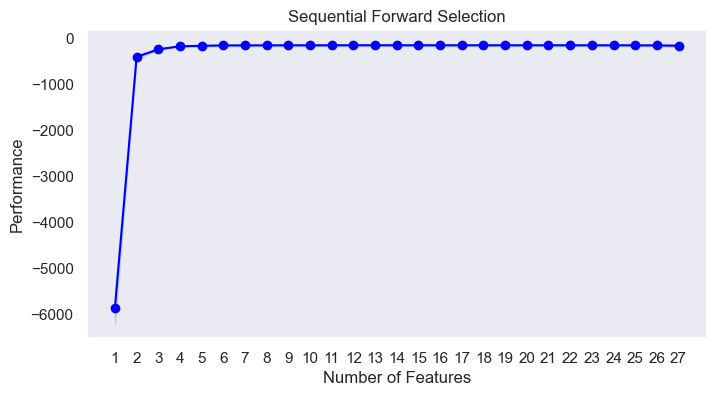

In [22]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

As we can see above, the **Sequential Feature Selection** method resulted in similar results to the **Pearson's Correlation** method. That said:
1. Again, we should follow the principle above to drop the sub-types of fat and keep *Fat.Total Lipid*.
2. This method indicates that micronutrients like *Vitamin B6* and *Copper*  may have a larger impact on *Kilocalories* than the others, but we will drop them all (aside from our dummy var *Vitamin E* present) because it will affect the interpretibility of our model - it may lead us to false conclusions (e.g. high Copper foods are super low cal!). Keeping some of these micronutrients may also cause multi-collinearity issues with the other micronutrients.
3. Interestingly, this method indicated that *Protein* may not be a good predictor of *Kilocalories*. This makes sense because high protein foods, unlike high fat foods tend to be lower in calories.
4. We see *Cholesterol* show up here, which could de-stabilize our model given its correlation to *Fat.Total Lipid*. We will keep it for now because it is a significant predictor of *Kilocalories* according to both methods.

Finally, let's use ***Variance Thresholding***. This is a simple method that removes features whose variance does not meet a certain threshold. Given our right-tailed histograms, we should take this step to ensure our features are decently spread out. We will use a threshold of 0.2.

Because we have a good idea of what our features are from the methods above, we will use the intersection of the features from the Pearson's Correlation method and the Sequential Feature Selection method and exclude anything that doesn't meet our threshold.

In [23]:
# Create a VarianceThreshold object with a threshold of 0.2
vt = VarianceThreshold(threshold=0.2)

# Create copy of our df for feature selection
df_fs_vt = df.copy()

# Only keep feature candidates
df_fs_vt = df_fs_vt.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

# Fit the VarianceThreshold object to ds_fs_ffs
vt.fit(df_fs_vt)

# Create a boolean mask from the VarianceThreshold object
mask = vt.get_support()

# Create a reduced dataset by applying the mask to ds_fs_ffs
reduced_ds_fs_ffs = df_fs_vt.loc[:, mask]

# Create a list of features to keep
df_selected_features = reduced_ds_fs_ffs.copy()

# Show the list of features to keep
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6943 entries, 0 to 7409
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Ash                                     6943 non-null   float64
 1   Carbohydrate                            6943 non-null   float64
 2   Cholesterol                             6943 non-null   int64  
 3   Fiber                                   6943 non-null   float64
 4   Kilocalories                            6943 non-null   int64  
 5   Protein                                 6943 non-null   float64
 6   Sugar Total                             6943 non-null   float64
 7   Water                                   6943 non-null   float64
 8   Fat.Monosaturated Fat                   6943 non-null   float64
 9   Fat.Polysaturated Fat                   6943 non-null   float64
 10  Fat.Saturated Fat                       6943 non-null   float64
 

This shows us that none of the features have a variance less than 0.2. None of the features will be excluded in this step.

Our best features seem to be the ones we identified in the correlation method. Let's keep those and move on.

In [24]:
# Our final features end up being the ones we identified in the correlation method
df_selected_features = df_fs_correlation.copy()

df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6943 entries, 0 to 7409
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Ash                                     6943 non-null   float64
 1   Carbohydrate                            6943 non-null   float64
 2   Cholesterol                             6943 non-null   int64  
 3   Fiber                                   6943 non-null   float64
 4   Kilocalories                            6943 non-null   int64  
 5   Protein                                 6943 non-null   float64
 6   Sugar Total                             6943 non-null   float64
 7   Water                                   6943 non-null   float64
 8   Fat.Total Lipid                         6943 non-null   float64
 9   Household Weights.1st Household Weight  6943 non-null   float64
 10  Vitamin E Present                       6943 non-null   int64  
d

## Model Building
Now that we have our features, let's build a few models to predict *Kilocalories*. We will use the following techniques to perform regression:
1. **OLS Linear Regression**
2. **GBM**
3. **AutoML's Best Model**

With each model, we will try to unpack how each model leverages the features to predict *Kilocalories*. For OLS regression, this will be as simple as assessing coefficents for OLS regression. For ensembling methods, we will first optimize RMSE by tuning hyperparameters with cross-validation to reduce overfitting before taking a look at e.g. variable importance. Later, we'll use SHAP values to compare the interpretability on the same scale.

### Train | Test Split
Let's take a moment to split our data into a training and test set. We will use 80% of the data for training and 20% for testing.

In [25]:
# Show initial shape of dataframe
print('Initial shape of dataframe:', df_selected_features.shape)

Initial shape of dataframe: (6943, 11)


In [26]:
# Convert the dataframe to an H2OFrame
df = h2o.H2OFrame(df_selected_features)

# Splitting the data into training and test sets
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows], seed = 1)

# Show shape of training set and test set
print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)

# Save the h2o frames back to a pandas dataframe
df_train_pd = df_train.as_data_frame()
df_test_pd = df_test.as_data_frame()

print('Training pd set shape:', df_train_pd.shape)
print('Test pd set shape:', df_test_pd.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set shape: (5568, 11)
Test set shape: (1375, 11)
Training pd set shape: (5568, 11)
Test pd set shape: (1375, 11)


In [27]:
# Setting the predictor and response variables
y = 'Kilocalories'
X = list(df.columns)
X.remove(y)

# Print predictors
print('Predictors:', X)

# Print response variable
print('Response:', y)

Predictors: ['Ash', 'Carbohydrate', 'Cholesterol', 'Fiber', 'Protein', 'Sugar Total', 'Water', 'Fat.Total Lipid', 'Household Weights.1st Household Weight', 'Vitamin E Present']
Response: Kilocalories


### OLS Linear Regression
Let's start by fitting a linear regression model to our data. We will use the sklearn library to fit the model and then use statsmodels.api to print a summary() method to view the results.

In [28]:
# Fit a linear regression model with default settings to training data with sklearn
from sklearn.linear_model import LinearRegression

# Create linear regression object
lm = LinearRegression()

# Train the model using the training sets
lm.fit(df_train_pd[X], df_train_pd[y])

# Save lm as an OLS model for summary() method
lm = sm.OLS(df_train_pd[y], df_train_pd[X]).fit()

# Print the summary of the model
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:           Kilocalories   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.524e+05
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                        0.00
Time:                        18:02:32   Log-Likelihood:                         -23637.
No. Observations:                5568   AIC:                                  4.729e+04
Df Residuals:                    5558   BIC:                                  4.736e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

Considering the P values of <0.05 tell us that the probability of a feature being uncorrelated to our target is low, the OLS regression method tells us the following about our predictors:

1. *Fat.Total Lipid* is the most important predictor of Kilocalories, followed by Protein and Carbohydrates. We expect our macronutrients to drive the majority of calories.
2. When it comes to negative predictors of Kilocalories, *Fiber* overindexes other features. Fiborous vegetables are low in calories, so this makes sense.
3. Surprisingly, *Water* is just barely significant. This is likely because the majority of foods are mostly water, so it is not a good predictor of Kilocalories. Also, foods like soups and stews are mostly water and have a lot of calories, so this may be why the coefficient is negative.
4. Also unexpectedly, *Sugar Total* has a relatively low coefficient and high p-value. This is likely because sugar is a type of carbohydrate and is already accounted for in the *Carbohydrate* feature.

### Gradient Boosting Machine (GBM)
Let's now fit a GBM model with the training data and see it's performance on cross-validation and testing data. We will use the default parameters for now.

In [29]:
# Create a GBM model with the training data
from h2o.estimators import H2OGradientBoostingEstimator

# Set up GBM for regression
gbm = H2OGradientBoostingEstimator(seed=1, model_id='gbm', nfolds= 5)

# Use .train() to build the model
gbm.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Print the GBM model
print(gbm)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          20972                  5            5            5             19            32            28.66

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 100.12868327733996
RMSE: 10.006432095274517
MAE: 5.58452080918112
RMSLE: 0.1666406181061381
Mean Residual Deviance: 100.12868327733996

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 127.07810032716681
RMSE: 11.272892278699677
MAE: 6.676260967361631
RMSLE:

As we tune our model, we want to keep our RMSE performance on the cross-validation set and testing in mind: 11.3 and 13.3. This is our baseline for how much our model is overfitting. An adjustment of a hyperparameter will be considered successful if it reduces the RMSE compared to this benchmark. 

We can also see that the model considers *Water* far and away the most important predictor, followed by *Fat Total Lipids*. Below I'll use the explain function to get visualize the importance.

In [ ]:
# Plot the variable importance
exm = gbm.explain(df_test, include_explanations=['varimp'])

We can rank significant predictors based on these results; for example, *Water* would be the most significant predictor, followed by *Fat.Total Lipids*, etc.

It makes a lot of sense that water would be a strong predictor of kilocalories. Though we saw above in the OLS regression that it isn't strongly negatively correlated to the response, it is a significant predictor of the response. Water has 0 calories, so food with high water content will have fewer kilocalories. It does not make sense that it would be so much more significant than the other predictors like *Fat Total Lipids*, *Protein*, and *Carbohydrate*, which are essential building blocks of food.

Beyond that, I think this model overstates the importance of insignificant micronutrients like Potassium. Because *Water* is so significant, the model makes it seem like *Sugar Total* is as significant as *Cholesterol*, which we know is not true. 

In order to test which hyperparameters are important for this GBM instance, I will tweak the following HPs and see how they affect the RMSE on the test set:
* Learn Rate
* ntrees
* Minimum Rows

In [30]:
from h2o.grid import H2OGridSearch

# GBM hyperparameters
gbm_params1 = {
    'learn_rate': [0.01, 0.1],  
    'ntrees': [100, 200],  
    'min_rows': [10, 20]  
}

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=gbm,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=X, y=y,
                training_frame=df_train,
                validation_frame=df_test,
                seed=1)

# Get the grid results, sorted by validation RMSE
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='rmse', decreasing=False)


# Let's see the grid
gbm_gridperf1

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,learn_rate,min_rows,ntrees,model_ids,rmse
,0.1,10.0,200.0,gbm_grid1_model_6,12.5550820
,0.1,20.0,200.0,gbm_grid1_model_8,12.6099402
,0.1,10.0,100.0,gbm_grid1_model_2,12.7592059
,0.1,20.0,100.0,gbm_grid1_model_4,12.9931492
,0.01,10.0,200.0,gbm_grid1_model_5,29.0444388
,0.01,20.0,200.0,gbm_grid1_model_7,29.4005708
,0.01,10.0,100.0,gbm_grid1_model_1,66.6114786
,0.01,20.0,100.0,gbm_grid1_model_3,66.6768509


All else held constant, we can see that Learn Rate has the biggest impact on our RMSE. We can observe smaller changes between two min_row and two ntree values, but when Learn Rate decreases from 0.1 to 0.01, RMSE shoots up by up to ~44 Kcals. This makes sense because Learn Rate is the step size of the gradient descent algorithm. A smaller step size means that the algorithm will take longer to converge, but it will be more accurate. Ntrees also seems to have a significant impact on RMSE, but not as much as Learn Rate. This makes sense because the more trees we have, the more accurate our model will be. 

Let's use the best parameters from the grid search for our final GBM model.

Now let's see if some regularization techniques will help reduce overfitting. Let's start by adjusting the max_depth hyperparameter. This parameter controls the maximum depth of individual trees, which thereby limits the complexity of the model.

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


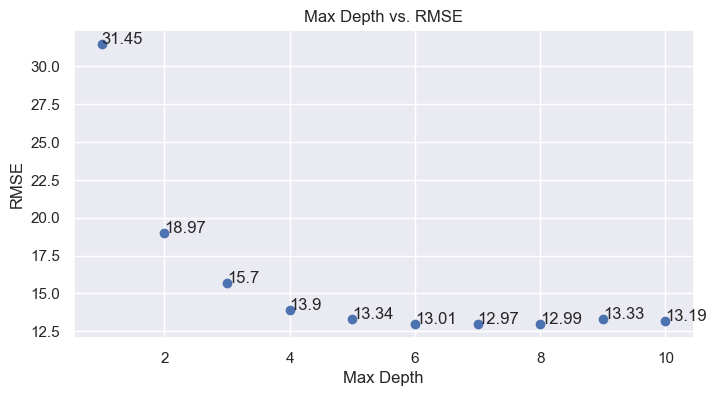

In [31]:
# Regularize model2 with max_depth
from h2o.estimators import H2OGradientBoostingEstimator

# select the values for max_depth to grid over
hyper_params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=gbm,
                          grid_id='gbm_grid',
                          hyper_params=hyper_params,)

# Train the grid
gbm_grid.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

# Get the grid results, sorted by validation RMSE
gbm_gridperf = gbm_grid.get_grid(sort_by='rmse', decreasing=True)

# Add the grid models to a dataframe
gbm_gridperf_df = gbm_gridperf._grid_json['summary_table'].as_data_frame()

# Plot max depth vs. RMSE
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Max Depth vs. RMSE')
plt.plot(gbm_gridperf_df['max_depth'], gbm_gridperf_df['rmse'], 'bo')
for i, txt in enumerate(gbm_gridperf_df['rmse']):
    # round to 2 decimals
    txt = round(txt, 2)
    plt.annotate(txt, (gbm_gridperf_df['max_depth'][i], gbm_gridperf_df['rmse'][i]))
plt.show()

We can see that the RMSE decreases as the max_depth increases to a point. This makes sense because the model is able to learn more complex relationships between the predictors and the response. However, we can see that the RMSE starts to increase again after max_depth = 7. If we look back to our original GBM model's performance and compare RMSE scores, we can see that the best value of this tuning exercise gave us 11.3 on the test set, whereas we got down to 12.97; we never get to our minimum RMSE here. 

This hyperparameter certainly has an impact on our model and how much it overfits, but it doesn't seem to be the most important lever for reducing overfitting.

Let's try one more regularization technique: adjusting sample rate. This parameter controls the row sampling rate which controls the number of rows used in training each tree.

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


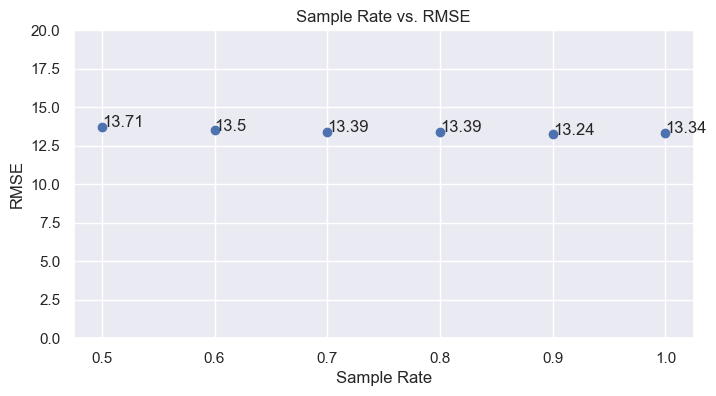

In [32]:
# Regularize model2 with sample_rate
from h2o.estimators import H2OGradientBoostingEstimator

# select the values for sample_rate to grid over
hyper_params = {'sample_rate': [0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# Train and validate a cartesian grid of GBMs
gbm_grid2 = H2OGridSearch(model=gbm,
                          grid_id='gbm_grid2',
                          hyper_params=hyper_params)

# Train the grid
gbm_grid2.train(x=X, y=y, training_frame=df_train, validation_frame=df_test, seed=1, nfolds=5)

# Get the grid results, sorted by validation RMSE
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='rmse', decreasing=True)

# Add the grid models to a dataframe
gbm_gridperf_df2 = gbm_gridperf2._grid_json['summary_table'].as_data_frame()

# Plot sample rate vs. RMSE
plt.xlabel('Sample Rate')
plt.ylabel('RMSE')
plt.title('Sample Rate vs. RMSE')
# Set y axis min to 0 and max to 20
plt.ylim(0, 20)
plt.plot(gbm_gridperf_df2['sample_rate'], gbm_gridperf_df2['rmse'], 'bo')
for i, txt in enumerate(gbm_gridperf_df2['rmse']):
    # round to 2 decimals
    txt = round(txt, 2)
    plt.annotate(txt, (gbm_gridperf_df2['sample_rate'][i], gbm_gridperf_df2['rmse'][i]))
plt.show()

After limited testing and because our best RMSE (13.24) is very similar to our baseline (13.3), we can conclude that adjusting this hyperparameter not as important as max_depth for reducing overfitting or residuals. There are many hyperparameters we can adjust to regularize and counteract overfitting in our GBM models, but we will stop here for now. Read more about GBM hyperparameters [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html#gbm-hyperparameters).

In [ ]:
# Finalize the GBM model
final_gbm = H2OGradientBoostingEstimator(seed=1, model_id='final_gbm', ntrees=200, learn_rate=0.1, min_rows=10, max_depth=7, sample_rate=0.9)

### AutoML Best (Non-Stacked) Model
Finally, let's use AutoML fit 20 models to our data and analyze the feature parameters of the best one by RMSE. I'm excluding ensembles because we will be cross-referencing SHAP scores down the line and we want to compare apples to apples. 

In [33]:
# Set up AutoML
aml = H2OAutoML(seed=1, max_models=20, stopping_metric='RMSE', sort_metric='RMSE', verbosity='info', exclude_algos = ["XGBoost", "DeepLearning"]) # Due to system limitations, I am only including specific algorithms that can run on my local machine for reproducibility

# Pass the data through H20AutoML set the seed for reproducibility
aml.train(x=X, y=y, training_frame=df_train, validation_frame=df_test)

AutoML progress: |
18:29:26.5: Project: AutoML_1_20231210_182925
18:29:26.6: 5-fold cross-validation will be used.
18:29:26.7: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
18:29:26.7: Setting stopping tolerance adaptively based on the training frame: 0.013401406685472435
18:29:26.7: Build control seed: 1
18:29:26.8: training frame: Frame key: AutoML_1_20231210_182925_training_py_2_sid_ad46    cols: 11    rows: 5568  chunks: 1    size: 159190  checksum: -4160072094784207146
18:29:26.8: validation frame: Frame key: py_3_sid_ad46    cols: 11    rows: 1375  chunks: 1    size: 40630  checksum: -4880629881149126922
18:29:26.8: leaderboard frame: NULL
18:29:26.8: blending frame: NULL
18:29:26.8: response column: Kilocalories
18:29:26.8: fold column: null
18:29:26.8: weights column: n

key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/20
# GBM base models (used / total),6/17
# DRF base models (used / total),0/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [36]:
# Grab the best model, excluding ensembles (third row)
best_model = h2o.get_model(aml.leaderboard[2, 'model_id'])

# Print the model details
best_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20231210_182925_model_12


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    76                 76                          77386                  7            7            7             20            111           76.2895

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 29.90922973090067
RMSE: 5.46893314375854
MAE: 3.1962956333768435
RMSLE: 0.08567237061171633
Mean Residual Deviance: 29.90922973090067

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 106.15180833350541
RMSE: 10.302999967655314
MAE: 5.517768761292997
RMSLE: 0.0626064321854619
Mean Residual Deviance: 106.15180833350541

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 130.64477220348726
RMSE: 11.4299944096
MAE: 5.465315942480039
RMSLE: 0.12479871641546676
Mean Residual Deviance: 130.64477220348726

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     5.4603    0.306585    5.75917       5.59582       5.36682       4.97248       5.60722
mean_residual_deviance  130.775   30.9211     131.103       171.278       134.028       84.2217       133.245
mse                     130.775   30.9211     131.103       171.278       134.028       84.2217       133.245
r2                      0.995631  0.00101431  0.99584       0.994277      0.995409      0.997106      0.995521
residual_deviance       130.775   30.9211     131.103       171.278       134.028       84.2217       133.245
rmse                    11.367    1.39969     11.45         13.0873       11.5771       9.17724       11.5432
rmsle                   0.11941   0.0404829   0.147106      0.176143      0.0887617     0.102122      0.0829185

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-12-10 18:29:54  14.427 sec  0                  172.955          136.423         29913.4              166.962            134.729           27876.2
    2023-12-10 18:29:54  14.444 sec  5                  103.113          81.2515         10632.2              99.7496            80.112            9949.98
    2023-12-10 18:29:54  14.463 sec  10                 61.8542          48.6935         3825.94              60.1092            48.1152           3613.12
    2023-12-10 18:29:54  14.478 sec  15                 37.7216          29.4922         1422.92              37.1087            29.4848           1377.05
    2023-12-10 18:29:54  14.492 sec  20                 23.8073          18.3152         566.789              24.0563            18.6666           578.707
    2023-12-10 18:29:54  14.505 sec  25                 15.8839          11.7796         252.299              16.992             12.494            288.729
    2023-12-10 18:29:54  14.522 sec  30                 11.5802          8.04941         134.101              13.3948            9.11017           179.421
    2023-12-10 18:29:54  14.535 sec  35                 9.28299          5.96241         86.1739              11.7679            7.38663           138.484
    2023-12-10 18:29:54  14.549 sec  40                 8.02444          4.82736         64.3917              11.0349            6.51071

### Using SHAP Values to Assess Model Interpretability
